# Vector calculus in ECCO: The Transport, divergence, vorticity and the Barotropic Vorticity Budget

## Using the xgcm and xmitgcm tools
This example calculation uses the xmitgcm and xgcm tool buildt by Rayan Abernathey. We borrow heavily from his documentation, adapting it to the ECCO data: https://xgcm.readthedocs.io/en/latest/example_mitgcm.html. Thanks for the great work Ryan!

## This tutorial: Transport, divergence, vorticity, and finally the batotropic *vorticity budget* 
This example ses the binary DMS data. We assume you have some background using python. We start from global calculations of *transport*, *divergence*, *vorticity*, and finally the *batotropic vorticity*. We then move on to calculateing vorticity budgets (using the batrotopic vorticity budget). We use this example as it is conceptually accessible, but technically a bit tricky because angles are involved. This means that it is extra important to have a good handle on the grid and where everything is in relation to everything else.

## Context for the barotropic vorticity budget
For context, the barotropic vorticity is arrived at taking the momentum equations of the ocean as a thin fluid on a rotating sphere:

\begin{equation}
\partial_t \mathbf{u} + f \mathrm{\textbf{k}} \times \mathbf{u} = - \dfrac{1}{\rho_0} \nabla p + \dfrac{1}{\rho_0} \partial_z \tau +  \mathrm{\textbf{a}} +\mathrm{\textbf{b}}, \\
\partial_z p = -g\rho,\\
\nabla \cdot \mathrm{\textbf{v}} = 0.
%  \label{thinFluidOnRotatingSphere}
\end{equation}
 
The pressure, acceleration due to gravity, density and vertical shear stress are denoted $p$, $g$, $\rho$ and $\tau$ respectively, with $\rho_0$ the reference density; the three dimensional velocity field $\textbf{v} = (u, v, w ) = (\textbf{u}, w)$; the unit vector is denoted $\textbf{k}$; planetary vorticity as a function of latitude $\phi$ in $f \mathrm{\textbf{k}}= (0, 0, 2\Omega sin \phi)$; the viscous forcing by vertical shear is denoted $\partial_z \tau$; the non-linear terms are $\textbf{a}$ and the horizontal viscous forcing $\textbf{b}$. Assuming steady state, the vertical integral from $z=\eta(x,y,t)$ to $z=H(x,y)$ gives


\begin{equation}
 0 = \nabla \cdot (f\mathbf{U})+\dfrac{1}{\rho_0} \nabla p_b \times \nabla H+\dfrac{1}{\rho_0}\nabla\times \mathbf{\tau} + \nabla \times \mathrm{\textbf{A}}+ \nabla \times \mathrm{\textbf{B}},
% \label{BV_eq}
\end{equation}

the bottom pressure is denoted $p_b$, $\mathrm{\textbf{A}}=\int^\eta_H \mathrm{\textbf{a}}\mathrm{d}z$ and $\mathrm{\textbf{B}}=\int^\eta_H \mathrm{\textbf{b}}\mathrm{d}z$. The LHS of the equation above is the planetary vorticity advective term, while the RHS of the equation above is the bottom pressure torque, the wind and bottom stress curl, the non-linear torque and the viscous torque, respectively.

For more detail, see Sonnewald et al. 2018: https://github.com/maikejulie/inPrep/blob/master/classificationManuscript.pdf


We start by loading some of the modules we will need. This is a basic step ensuring the tools python will need are available.

In [1]:
import numpy as np
import xarray
import dask.array as daskarray
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import SymLogNorm
from xmitgcm import open_mdsdataset
import xgcm
from mpl_toolkits.basemap import Basemap, cm, shiftgrid
import xarray as xr

## Using the MDS ECCOv4r2 data 

For this work, I modified the "data.diagnostics" file a little, because I wanted some specific outputs. Using xmitgcm, we can read the binary files that my ECCO run produces. 

The matadata needs to be available, and for an example download the data here:
```bash
curl -L -J -O https://ndownloader.figshare.com/files/6494721
tar -xvzf global_oce_llc90.tar.gz```


### Loading the binary MDS files, the metadate and creating a "grid" object

For loading the data, we use the comand "open_mdsdataset". The directory given is where the data is, and we have control over how many timesteps or "iters" we extract (here "all"), the geometry (here the LatLongCap "llc") and many other things. The documentation is great!

In [3]:
#Wondering how the "open_mdsdataset" works? Try looking at the documentation by running the command below!
open_mdsdataset?

In [14]:
ds_llc = open_mdsdataset('global_oce_llc90/', iters=8, geometry='llc')

We now have an object "ds_llc", where our variables are housed, along with metadata. For more information of the metadata, particularily what points they reference, I made a little table:


| Name        | Dimensions           | Long name (location, notes)  |
| ------------- |:-------------:| -----:|
|    XC   |   face, i, j    |   Longitude (tracer)   |
|    YC   |   face, i, j    |   Latitude (tracer)   |
|    RC   |    k   |   Depth (tracer)   |
| ------------- |  |  |
|   XG    |   face, i, j    |   Longitude (vorticity)   |
|    YG   |   face, i, j    |   Latitude (vorticity)   |
|    RF   |   k    |   Depth (velocity)   |
| ------------- |  |  |
|   DXC    |   face, i, j    |   grid spacing (tracer, i)   |
|    DYC   |   face, i, j    |   grid spacing (tracer, j)   |
|   DRC    |   k    |   grid spacing (tracer, k)   |
|   RAC    |   face, i, j    |   grid cell area (tracer)   |
| ------------- |  |  |
|   DXG    |   face, i, j    |   grid spacing (vorticity, i)   |
|   DYG    |   face, i, j    |   grid spacing (vorticity, j)   |
|   DRF    |   k    |   grid spacing (vorticity, k)   |
|   RAZ    |   face, i, j    |   grid cell area (vorticity)   |
| ------------- |  |  |
|   Depth    |   face, i, j    |   ocean bottom depth (tracer)   |
|   hFacC    |   k, face, i, j    |   partial cell factor (tracer)   |
|   hFacS    |   k, face, i, j    |   partial cell factor (velocity, j)   |
|   hFacW    |   k, face, i, j    |   partial cell factor (velocity, i)   |


Notice that we have the metadata on both tracer and velocity points. This can be in important distinction!



Table modified from http://wwwcvs.mitgcm.org/viewvc/MITgcm/MITgcm_contrib/gael/matlab_class/gcmfaces.pdf?view=co

We can have a look at the content of the object by calling it. To get at the variables, we go "ds_llc.variable". The dimenstions have the extra "face" attribute, which are the different tiles in the ECCO LLC grid. 


In [11]:
#We can have a look at the contents of a dataset object by calling the name.
ds_llc

<xarray.Dataset>
Dimensions:   (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 240)
Coordinates:
  * k_p1      (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_l       (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    iter      (time) int64 dask.array<shape=(240,), chunksize=(1,)>
  * time      (time) int64 732 1428 2172 2892 3636 4356 5100 5844 6564 7308 ...
    XC        (face

## Transport and divergence calculations

We start with some transport calculations. This is something where we need to know the cell dimentions etc. so the meta data comes in really handy. 

The object we created loading the data "ds_llc" is where our data is stored. We access the fields with the dot syntax (U field is ds_llc.U), and can perform opperations associated with this field using the same syntax (mean across the variable 'time' is ds_llc.U.mean('time')). Calculating transport following:

In [15]:
u_transport_llc = (ds_llc.U.mean('time')) * ds_llc.dyG * ds_llc.hFacW * ds_llc.drF
v_transport_llc = (ds_llc.V.mean('time')) * ds_llc.dxG * ds_llc.hFacS * ds_llc.drF

To plot the data, we employ a slight hack, where we simply twist the faces until the match up. This involves ignoring the Arctic for now (sorry!), and means that the overlap region between the faces is currently not treated very elegantly. This should be fixed in the future, and please refer back to this tutorial/subscribe to our email list to know when we update this!

In [20]:
u_transport_llc_collated,lat_collated,lon_collated=getField(u_transport_llc[0])
v_transport_llc_collated,lat_collated,lon_collated=getField(v_transport_llc[0])

/home/maike/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/maike/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'shading'
  s)
/home/maike/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/maike/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/maike/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprec

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

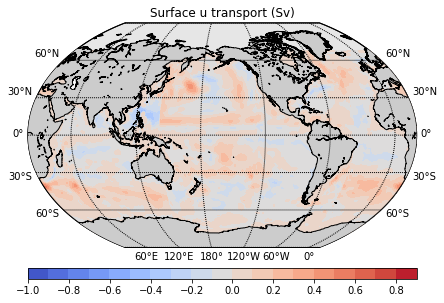

In [21]:
makeFig(u_transport_llc_collated/1e6, -1, 1, 0.1, "Surface u transport (Sv)", plt.cm.coolwarm, 'surf_u_transp.png')

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

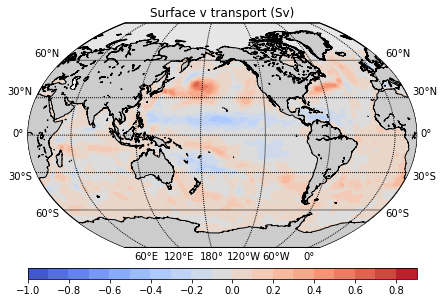

In [22]:
makeFig(v_transport_llc_collated/1e6, -1, 1, 0.1, "Surface v transport (Sv)", plt.cm.coolwarm, 'surf_v_transp.png')

For the divergence, we do something similar. 

(from the docs xmitgcm website)

∂u∂x+∂v∂y+∂w∂z=0.

In discrete form, using MITgcm notation, the equation becomes

δiΔygΔrfhwu+δjΔxgΔrfhsv+δkAcw=δkAc(E−P)r=0

In [23]:
div_uv_llc = (grid_llc.diff(u_transport_llc, 'X') + grid_llc.diff(v_transport_llc, 'Y'))

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

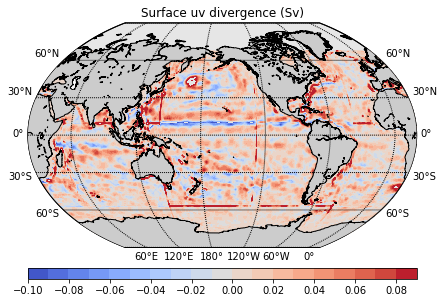

In [24]:
div_uv_llc_collated,lat_collated,lon_collated=getField(div_uv_llc[0])
makeFig(div_uv_llc_collated/1e6, -1e-1, 1e-1, 0.1e-1, "Surface uv divergence (Sv)", plt.cm.coolwarm, 'surf_uv_divergence.png')

## Calculating vorticity

We start (again borrowing from the xmitgcm docs) with the vertical component: 

ζ=−∂u∂y+∂v∂x.

On the c-grid, a finite-volume representation is given by
ζ=(−δjΔxcu+δiΔycv)/Aζ .



In [25]:
zeta = (-grid_llc.diff(ds_llc.U.mean('time') * ds_llc.dxC, 'Y') + grid_llc.diff(ds_llc.V.mean('time') * ds_llc.dyC, 'X'))/ds_llc.rAz

/home/maike/anaconda2/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in divide
  return func(*args2)
/home/maike/anaconda2/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in divide
  return func(*args2)


may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

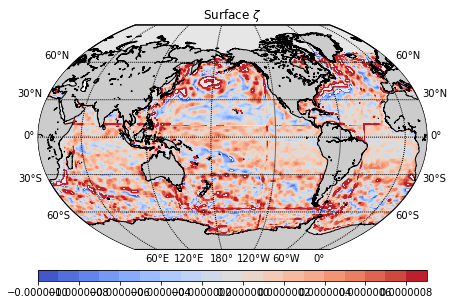

In [26]:
zeta_collated,lat_collated,lon_collated=getField(zeta[0])
makeFig(zeta_collated, -1e-6, 1e-6, 0.1e-6, "Surface $\zeta$", plt.cm.coolwarm, 'surf_zeta.png')

### Barotropic vorticity

The depth-integrated (barotropic) version of this quanitiy is interesting:

In [27]:
zeta_bt = (zeta * ds_llc.drF).sum(dim='k')

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

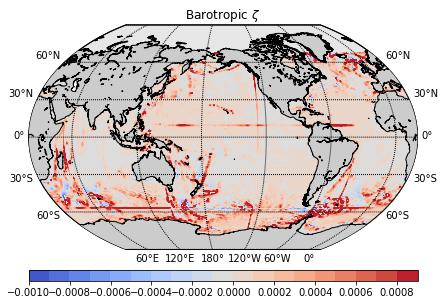

In [28]:
zeta_bt_collated,lat_collated,lon_collated=getField(zeta_bt)
makeFig(zeta_bt_collated, -1e-3, 1e-3, 0.1e-3, "Barotropic $\zeta$", plt.cm.coolwarm, 'bt_zeta.png')

## The Barotropic vorticity budget

### Loading the binary MDS files from my own run

For the budget, I modified the "data.diagnostics" file from an ECCOv4r2 run a little, because I wanted some specific outputs.

For loading the data, we use the comand "open_mdsdataset" again. The directory given is where the data is, and we have control over how many timesteps (here "all"), the geometry (here the LatLongCap "llc") and many other things. Check out the documentation using "open_mdsdataset?", it's great!

In [5]:
ds_llc = open_mdsdataset('global_oce_llc90/ecco4r2', iters='all', geometry='llc')

/home/maike/anaconda2/lib/python2.7/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/maike/anaconda2/lib/python2.7/site-packages/xmitgcm/mds_store.py:220: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [30]:
ds_llc

<xarray.Dataset>
Dimensions:   (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 240)
Coordinates:
  * k_p1      (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_l       (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    iter      (time) int64 dask.array<shape=(240,), chunksize=(1,)>
  * time      (time) int64 732 1428 2172 2892 3636 4356 5100 5844 6564 7308 ...
    XC        (face

Now we need to tell xgcm what our axes are like. We create a "grid" object with the dataset as an argument. We have periodic axes, so we create a grid object:

In [6]:
xgcm.Grid?

In [6]:
grid_llc = xgcm.Grid(ds_llc, periodic=['X', 'Y'])
grid_llc

<xgcm.Grid>
Y Axis (periodic):
  * center   j (90) --> left
  * left     j_g (90) --> center
X Axis (periodic):
  * center   i (90) --> left
  * left     i_g (90) --> center
Z Axis (not periodic):
  * center   k (50) --> left
  * left     k_l (50) --> center
  * outer    k_p1 (51) --> center
  * right    k_u (50) --> center
T Axis (not periodic):
  * center   time (240)

We have to do some opperations repeatedly, accomodating the format of the ECCO output, so let's put them is a seperate function:

In [7]:
def makeVectorECCO_global(vector):
    """Function taking a vector in depth (k) and repeating it to make a gloabl field (k, faces, j, i)."""
    return np.rollaxis(np.tile(vector,[13,90,90,1]).transpose(),3,1)

def repeatFieldInTime(field, timesteps, depthToo):
    """Function repeating a field (k, faces, j, i) in time, returning a field with 
    dimentions (time, k, face, j, i) if 'depthToo'==1, and otherwise a field with 
    dimentions (time, face, j, i)"""
    field_repeated = np.repeat(np.reshape(np.array(field), [1,13,90,90]),240,axis=0)
    if depthToo==1: 
        field_repeated = np.repeat(np.reshape(np.array(field), [1,1,13,90,90]),240,axis=0)
        field_repeated = np.repeat(np.reshape(field_repeated, [240,1,13,90,90]),50,axis=1)
    return field_repeated


To compute the appropriate Vertical Viscous Flux of U momentum (Implicit part), we vertically integrate. This involves extrapolating the initially 'time, face, j, i' field initially, and using the "diff" opperator along the vertical axis. Using the hFacS and hFacW we take the partial cells into account.

In [16]:
timesteps = 240
latViscV = ds_llc.VISrI_Vm/repeatFieldInTime(ds_llc.rAs, timesteps, 1)
gridSpacingV = ds_llc.hFacS*makeVectorECCO_global(ds_llc.drF)
diffZlatViscV = grid_llc.diff(latViscV, 'Z', boundary='fill')
latViscV = diffZlatViscV/gridSpacingV

In [17]:
latViscU = ds_llc.VISrI_Um/repeatFieldInTime(ds_llc.rAw, timesteps, 1)
gridSpacingU = ds_llc.hFacW*makeVectorECCO_global(ds_llc.drF)
diffZlatViscV = grid_llc.diff(latViscU, 'Z', boundary='fill')
latViscU = diffZlatViscV/gridSpacingU

To have the right pressure field, we need to combine the contribution of the hydrostatic pressure gradient ($\phi_{hyd}$) and the surface component ($\phi_{surf}$). The Hydrostatic part is readily available, but we need manipulate the $\eta$ field slightly:

In [10]:
ETAN=(1/9.81)*ds_llc.PHI_SURF
dETANdx = grid_llc.diff(ETAN, 'X') / repeatFieldInTime(ds_llc.dxC,240,0)
depth_x=np.nansum(ds_llc.hFacW*makeVectorECCO_global(ds_llc.drF), axis=0) #Den e bra
Um_dETANdx=dETANdx*depth_x

dETANdy = grid_llc.diff(ETAN, 'Y') / repeatFieldInTime(ds_llc.dyC,240,0)
depth_y=np.nansum(ds_llc.hFacS*makeVectorECCO_global(ds_llc.drF), axis=0) #Den e bra
Vm_dETANdy=dETANdy*depth_y

### Barotropic vorticity

This is what I'm personally quite excited by! It's one of those fundamental quantities that are a bit hard to warp your head around, but making them easier to calculate will make it more accessible.

We start (again borrowing from the xmitgcm docs) with the vertical component of the three-dimensional vorticity: 

ζ=−∂u∂y+∂v∂x.

On the c-grid, a finite-volume representation is given by
ζ=(−δjΔxcu+δiΔycv)/Aζ .

We now apply this to the components of the depth integrated momentum equation equation, where we take the 20 year average. 

In [18]:
Um_Ext_int = depthIntVelocity_i(ds_llc.Um_Ext)
Vm_Ext_int = depthIntVelocity_j(ds_llc.Vm_Ext)

UBotDrag_int = depthIntVelocity_i(ds_llc.UBotDrag)
VBotDrag_int = depthIntVelocity_j(ds_llc.VBotDrag)

Um_Cori_int = depthIntVelocity_i(ds_llc.Um_Cori)
Vm_Cori_int = depthIntVelocity_j(ds_llc.Vm_Cori)

Um_dPHdx_int = depthIntVelocity_i(ds_llc.Um_dPHdx)
Vm_dPHdy_int = depthIntVelocity_j(ds_llc.Vm_dPHdy)

Um_Diss_int = depthIntVelocity_i(ds_llc.Um_Diss)
Vm_Diss_int = depthIntVelocity_j(ds_llc.Vm_Diss)

latViscU_int = depthIntVelocity_i(latViscU)
latViscV_int = depthIntVelocity_j(latViscV)

Um_Advec_int = depthIntVelocity_i(ds_llc.Um_Advec)
Vm_Advec_int = depthIntVelocity_j(ds_llc.Vm_Advec)

AB_gU_int = depthIntVelocity_i(ds_llc.AB_gU)
AB_gV_int = depthIntVelocity_j(ds_llc.AB_gV)

TOTUTEND_int = depthIntVelocity_i(ds_llc.TOTUTEND)
TOTVTEND_int = depthIntVelocity_j(ds_llc.TOTVTEND)


The surface and bottom stress terms are added together to make up $\nabla \times \tau$

In [20]:
zeta_wind_int = (-grid_llc.diff(Um_Ext_int.mean(dim='time') * ds_llc.dxC, 'Y') + 
                 grid_llc.diff(Vm_Ext_int.mean(dim='time') * ds_llc.dyC, 'X'))/ds_llc.rAz
zeta_bottomDrag_int = (-grid_llc.diff(UBotDrag_int.mean(dim='time') * ds_llc.dxC, 'Y') +
                       grid_llc.diff(VBotDrag_int.mean(dim='time') * ds_llc.dyC, 'X'))/ds_llc.rAz
zeta_tau_bt = zeta_wind_int+zeta_bottomDrag_int


The planetary advection term $\nabla \cdot(f\mathbf{U})$ 

In [21]:
zeta_cori_bt = (-grid_llc.diff(Um_Cori_int.mean(dim='time') * ds_llc.dxC, 'Y') + 
                grid_llc.diff(Vm_Cori_int.mean(dim='time') * ds_llc.dyC, 'X'))/ds_llc.rAz

The bottom pressure torque $\nabla p_b \times \nabla H$ as the sum of contributions from $\phi_{hyd}$ and $\phi_{surf}$ 

In [22]:
zeta_phiHyd_int = (-grid_llc.diff((Um_dPHdx_int.mean(dim='time')) * ds_llc.dxC, 'Y') + 
                   grid_llc.diff((Vm_dPHdy_int.mean(dim='time')) * ds_llc.dyC, 'X'))/ds_llc.rAz
zeta_phiSurf_int = (-grid_llc.diff((Um_dETANdx.mean(dim='time')) * ds_llc.dxC, 'Y') + 
                    grid_llc.diff((Vm_dETANdy.mean(dim='time')) * ds_llc.dyC, 'X'))/ds_llc.rAz
zeta_bpt_bt = zeta_phiHyd_int+zeta_phiSurf_int

The non-linear terms $\nabla \times \mathbf{A}$

In [23]:
zeta_Diss_int = (-grid_llc.diff(Um_Diss_int.mean(dim='time') * ds_llc.dxC, 'Y') + 
                 grid_llc.diff(Vm_Diss_int.mean(dim='time') * ds_llc.dyC, 'X'))/ds_llc.rAz
zeta_ViscLat_int = (-grid_llc.diff(latViscU_int.mean(dim='time') * ds_llc.dxC, 'Y') + 
                    grid_llc.diff(latViscV_int.mean(dim='time') * ds_llc.dyC, 'X'))/ds_llc.rAz
zeta_A_bt = (zeta_Diss_int-zeta_bottomDrag_int)+zeta_ViscLat_int


and finally the viscous terms $\nabla \times \mathbf{B}$

In [33]:
zeta_Adv_int = (-grid_llc.diff(Um_Advec_int.mean(dim='time') * np.array(ds_llc.dxC), 'Y') + 
                grid_llc.diff(Vm_Advec_int.mean(dim='time') * np.array(ds_llc.dyC), 'X'))/ds_llc.rAz
zeta_AB_int = (-grid_llc.diff(AB_gU_int.mean(dim='time') * ds_llc.dxC, 'Y') + 
               grid_llc.diff(AB_gV_int.mean(dim='time') * ds_llc.dyC, 'X'))/ds_llc.rAz
zeta_B_bt = (zeta_Adv_int-zeta_cori_bt)+zeta_AB_int

In [32]:
zeta_Adv_int.shape, Vm_Advec_int.shape, ds_llc.dxC.shape

((13, 90, 90, 90, 90), (240, 13, 90, 90), (13, 90, 90))

We now stitch together the faces for plotting. This an ugly step that wll become depreciated once the exchange routines have been finished; something we are working on that should happen soon!

In [26]:
zeta_A_bt_collated,lat_collated,lon_collated=getField(zeta_A_bt)

/home/maike/anaconda2/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in divide
  return func(*args2)
/home/maike/anaconda2/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in divide
  return func(*args2)
/home/maike/anaconda2/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in subtract
  return func(*args2)
/home/maike/anaconda2/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in add
  return func(*args2)


In [39]:
zeta_B_bt_collated,lat_collated,lon_collated=getField(zeta_B_bt)

In [40]:
zeta_cori_bt_collated,lat_collated,lon_collated=getField(zeta_cori_bt)

In [41]:
zeta_pbt_bt_collated,lat_collated,lon_collated=getField(zeta_bpt_bt)

/home/maike/anaconda2/lib/python2.7/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in multiply
  return func(*args2)
/home/maike/anaconda2/lib/python2.7/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [42]:
zeta_tau_bt_collated,lat_collated,lon_collated=getField(zeta_tau_bt)

In [43]:
%store zeta_A_bt_collated
%store zeta_B_bt_collated
%store zeta_cori_bt_collated
%store zeta_tau_bt_collated
%store zeta_bpt_bt_collated
#%store depthAvTorque_av_collated

Stored 'zeta_A_bt_collated' (ndarray)
Stored 'zeta_B_bt_collated' (ndarray)
Stored 'zeta_cori_bt_collated' (ndarray)
Stored 'zeta_tau_bt_collated' (ndarray)


UsageError: Unknown variable 'zeta_bpt_bt_collated'


/home/maike/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()


may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

/home/maike/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'shading'
  s)
/home/maike/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/maike/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/maike/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


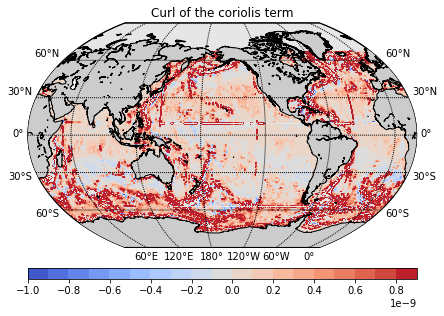

In [44]:
makeFig(zeta_cori_bt_collated, -1e-9, 1e-9, 0.1e-9, "Curl of the coriolis term", plt.cm.coolwarm, 'zeta_cori_bt.png')

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

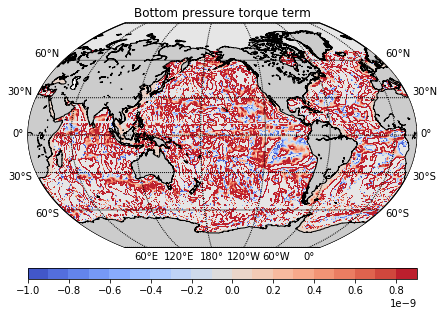

In [45]:
makeFig(zeta_pbt_bt_collated, -1e-9, 1e-9, 0.1e-9, "Bottom pressure torque term", plt.cm.coolwarm, 'zeta_bpt_bt.png')

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

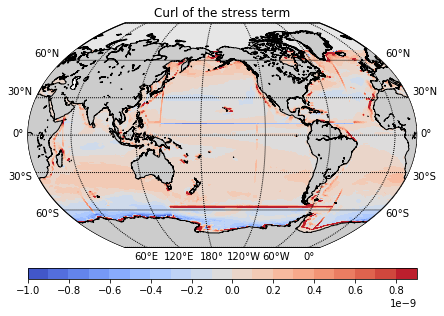

In [46]:
makeFig(zeta_tau_bt_collated, -1e-9, 1e-9, 0.1e-9, "Curl of the stress term", plt.cm.coolwarm, 'zeta_tau_bt.png')

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

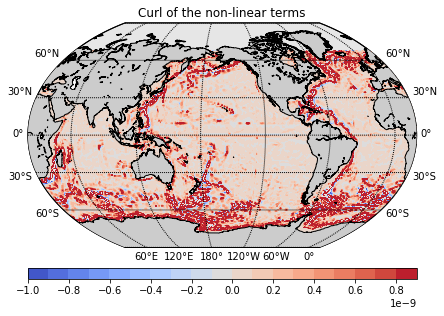

In [47]:
makeFig(zeta_A_bt_collated, -1e-9, 1e-9, 0.1e-9, "Curl of the non-linear terms", plt.cm.coolwarm, 'zeta_a_bt.png')

may not be what you expect.  If it looks odd, your can either
adjust the map projection region to be consistent with your data, or
(if your data is on a global lat/lon grid) use the shiftgrid
function to adjust the data to be consistent with the map projection
region (see examples/contour_demo.py).

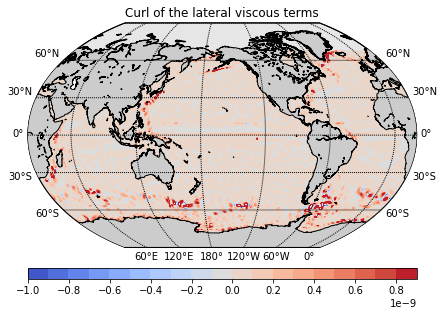

In [48]:
makeFig(zeta_B_bt_collated, -1e-9, 1e-9, 0.1e-9, "Curl of the lateral viscous terms", plt.cm.coolwarm, 'zeta_b_bt.png')

In [49]:
makeFig(zetaBT_collated, -1e-9, 1e-9, 0.1e-9, "Curl of the barotropic velocity field", plt.cm.coolwarm, 'test_zeta_bt.png')

NameError: name 'zetaBT_collated' is not defined

For my own purposes, I hacked together a globe for plotting, just rotating and flipping the "faces". In my workflow, these exsist as a little library I load. I added them here as an example of what-not-to-do. It's very tedious. 

In [11]:
def makeVectorECCO_global(vector):
    """Function taking a vector in depth (k) and repeating it to make a gloabl field (k, faces, j, i)."""
    return np.rollaxis(np.tile(vector,[13,90,90,1]).transpose(),3,1)

def repeatFieldInTime(field, timesteps, depthToo):
    """Function repeating a field (k, faces, j, i) in time, returning a field with 
    dimentions (time, k, face, j, i) if 'depthToo'==1, and otherwise a field with 
    dimentions (time, face, j, i)"""
    field_repeated = np.repeat(np.reshape(np.array(field), [1,13,90,90]),240,axis=0)
    if depthToo==1: 
        field_repeated = np.repeat(np.reshape(np.array(field), [1,1,13,90,90]),240,axis=0)
        field_repeated = np.repeat(np.reshape(field_repeated, [240,1,13,90,90]),50,axis=1)
    return field_repeated

def depthIntVelocity_i(field):
    """Time mean and depth integrated version of the given field on tracer point."""
    return (field * np.array(ds_llc.drF * ds_llc.hFacW)).sum(dim='k')


def depthIntVelocity_j(field):
    """Time mean and depth integrated version of the given field on tracer point."""
    return (field * np.array(ds_llc.drF * ds_llc.hFacS)).sum(dim='k')

In [2]:
def getField(field):
    """Rotating the different faces so they fit together. Takes a field on the 
    ECCOv4r2 llc grid with dimensions (face, i, j), and returns a field with (90*4,90*3).
    Unfortunately we ingore the Arctic..."""
    field_collated=np.zeros([90*4,90*3])
    lon_collated=np.zeros([90*4,90*3])
    lat_collated=np.zeros([90*4,90*3])
    x, y, nr = 3, 2, 4
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 3, 1, 5
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 3, 0, 6
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 0, 2, 1
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 0, 1, 2
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 0, 0, 3
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, rot90Case(getFace(nr, field)))
    x, y, nr = 1, 0, 11
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 1, 1, 12
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 1, 2, 13
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 2, 0, 8
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 2, 1, 9
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    x, y, nr = 2, 2, 10
    field_collated, lat_collated, lon_collated = addToMatrix(field_collated, lon_collated, lat_collated, x, y, fliplrCase(getFace(nr, field)))
    return field_collated, lat_collated, lon_collated



In [3]:
#We need to glue together the "faces" of ECCOv4
def getFace(faceNr, field):
    """Extracting the face to be treated, along with the matching lat and long."""
    f =xr.open_dataset('/home/maike/Documents/ECCO4_rel2/PHIBOT/PHIBOT.00{:02d}.nc'.format(faceNr))
    fieldRet = field[faceNr-1,:,:]
    lat = f.lat
    lon = f.lon
    return fieldRet, lat, lon

def rot90Case((fieldRet, lat, lon)):
    """The case where a face needs to be rotated."""
    fieldRet=np.flipud(np.rot90(fieldRet,3))
    lon=np.flipud(np.rot90(lon,3))
    lat=np.flipud(np.rot90(lat,3))
    return fieldRet, lat, lon

def fliplrCase((fieldRet, lat, lon)):
    """The case where the face needs to be flipped left to right."""
    fieldRet=np.flipud(fieldRet)
    lon=np.flipud(lon)
    lat=np.flipud(lat)
    return fieldRet, lat, lon

def addToMatrix(field_collated, lon_collated, lat_collated, x, y, (fieldRet, lat, lon)):
    """Adding the field to the overall matrix."""
    field_collated[90*x:90*(x+1), 90*y:90*(y+1)]=fieldRet
    lon_collated[90*x:90*(x+1), 90*y:90*(y+1)]=lon
    lat_collated[90*x:90*(x+1), 90*y:90*(y+1)]=lat
    return field_collated, lat_collated, lon_collated

Similarly, I plot using the basemap package. It's worked for me. I rudely ignotre the Arctic though, because interpolation is hard. This is pretty hard-coded to my *personal* workflow, so really just intended for inspirations.

In [4]:
def makeFig(data, cMin, cMax, cStep, title, ColMap, saveName):
    """
    Example of a plot using latitude and longitude. The 'data' is the field 
    we want to plot, cMin, cMax and cStep are the min, max and step of the colurbar. 
    Give the title of the plot as 'Plot title', the colour map needs to be specified
    next, and lastly the name to save the plot under e.g, 'title.png'. 
    
    Example usage: 
    makeFig(zeta_tau_bt_collated, -1e-9, 1e-9, 0.1e-9, "Curl of the stress term", plt.cm.coolwarm, 'zeta_tau_bt.png')
    """"
    plt.figure(figsize=(20,12))
    lons = lon_collated[:,1]
    lats = lat_collated[1,:]
    llons, llats = np.meshgrid(lons,lats)
    fig = plt.figure()
    ax = fig.add_axes([0.05,0.05,0.9,0.9])
    m = Basemap(projection='kav7',lon_0=200,resolution='l')
    im1 = m.contourf(llons,llats,np.fliplr(np.rot90(data,3)),np.arange(cMin, cMax, cStep),shading='flat',cmap=ColMap,latlon=True)
    m.drawmapboundary(fill_color='0.9')
    m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,1])
    m.drawmeridians(np.arange(-180.,180.,60.),labels=[1,1,0,1])
    m.drawcoastlines()
    m.fillcontinents()
    cb = m.colorbar(im1,"bottom", size="5%", pad="9%")
    ax.set_title(title)
    plt.savefig(saveName, format='png', dpi=500, bbox_inches='tight')
    plt.show()